# Test Technique  (bonus)

**Author:** [Yannis Tannier](https://github.com/yannistannier)<br>
**Date created:** 2021/10/16<br>
**Last modified:** 2021/10/19<br>

## Style Robustness : Entrainement avec test de robustesse sur le style (Microsoft)

In [1]:
import os
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


On définit nos hyperparamètres 

In [3]:
BATCH_SIZE = 32
NUM_CLASSES = 50
IMG_SIZE = 120

On doit à présent récupérer notre jeu d'entrainement et le devisier en fonction des labels de test references :

In [13]:
csv = []
for image in glob.glob(os.path.join("/SSD/DGFIP_2/Icons-50/", "*", "*.png")):
    
    info = os.path.basename(image).split("_")
    company = info[0]
    style = "_".join(info[2:])[:-4]
    
    if company == "microsoft":
        train_test = "test"
    else:
        train_test = "train"
    csv.append({"name": image, "label_name": image.split("/")[-2], "type": train_test})

In [16]:
df = pd.DataFrame(csv)

In [17]:
train = df[df["type"] == "train"]
test = df[df["type"] == "test"]

In [18]:
len(train), len(test)

(8735, 1265)

In [19]:
test.head()

,name,label_name,type
3,/SSD/DGFIP_2/Icons-50/writing_utensil/microsof...,writing_utensil,test
25,/SSD/DGFIP_2/Icons-50/writing_utensil/microsof...,writing_utensil,test
51,/SSD/DGFIP_2/Icons-50/writing_utensil/microsof...,writing_utensil,test
55,/SSD/DGFIP_2/Icons-50/writing_utensil/microsof...,writing_utensil,test
64,/SSD/DGFIP_2/Icons-50/writing_utensil/microsof...,writing_utensil,test


On ajoute au jeux d'entrainement les images augmentées provenant uniquement du jeu d'entrainement :

In [22]:
data_augmix = pd.read_csv("../data_augmix.csv")

train = train.append(
    data_augmix[data_augmix["source"].isin(train["name"])]
)

In [28]:
train["label_name"] = pd.Categorical(train["label_name"])
test["label_name"] = pd.Categorical(test["label_name"])

In [29]:
test["label"] = test["label_name"].cat.codes

In [26]:
classes_indices = { l: x for x,l in enumerate(train["label_name"].cat.categories)}

In [30]:
train["label"] = [ classes_indices[x] for x in train["label_name"]]
test["label"] = [ classes_indices[x] for x in test["label_name"]]

In [161]:
train.to_csv("train_style.csv", index=False)
test.to_csv("test_style.csv", index=False)

Notre première approche consiste en un fine-tuning d'un EfficientNet-B0.   

Pour cela nous importons **EfficientNetB0** de keras application avec le paramètre weights à "imagenet" car nous voulons importer les poids du modèle entrainé sur ImageNet. ImageNet étant une base de données composées de plus d'un million d'images, les valeurs des kernels (= les poids du modèle) appris sur ImageNet sont de la grande valeur. Même si notre jeu de données ne ressemble pas exactement aux images d'ImageNet, il est souvent plus intéressant de récupérer les poids d'un modèle entrainé sur ImageNet que d'initialiser les poids de façon aléatoire.   

On ajoute 4 couches après notre backbone (EfficientNetB0):    
- Une couche de GlobalAveragePooling2D pour réduire la dimension des features maps de sortie du backbone et également "aplatir" la matrice (l'équivalent d'un reshape d'une matrice 3D à 2D)
- Suivi d'une couche de BatchNormalization qui fait office de régularisation
- Puis d'une couche de Dropout, toujours pour régulariser notre réseau
- Et enfin une couche de Dense avec softmax avec N (le nombre de neurones) égale à notre nombre de label

L'entrainement se fera en 2 temps :    
- Premièrement nous allons de freeze toutes les couches de notre backbone (les couches d'EfficientNetB0) et entrainer avec un important learning (1e-2) puis le baisser progressivement jusqu'à (1e-4). Nous faisons cela car nous allons ajouter de nouvelle couches à notre réseau et nous voulons d'abord entrainer ces nouvelles couches afin de ne pas trop modifier les valeurs des poids du réseau au début de l'apprentissage, là où l'erreur sera la plus grande et donc le gradient élevée lors de la back propagation.   


- Dans un second temps, nous allons unfreeze la quasi-totalité du réseau et entrainer avec un faible learning rate (1e-4). Ce deuxième entrainement permet de spécialiser notre réseau dans son ensemble à la tache souhaitée.

In [35]:
def build_model(learning_rate=1e-2):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False
    
    output = model.output
  
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(50, activation="softmax", name="logit")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetb0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')]
    )
    return model

In [36]:
def run_train(model, train_generator, val_generator, epochs, save_weights="model_best.h5", verbose=1):
    def scheduler(epoch, lr):
        if epoch < 5:
            return lr
        if epoch < 30:
            return lr*0.1
        return lr*0.01

    if verbose > 0:
        print("First Training : Backbone freeze\n")
    
    freeze_hist = model.fit(train_generator, 
                            epochs=epochs, 
                            validation_data=val_generator, 
                            verbose=verbose,
                            use_multiprocessing = True,
                            max_queue_size=20,
                            workers = 20,
                            callbacks=[
                                tf.keras.callbacks.LearningRateScheduler(scheduler)
                            ])
    
    if verbose > 0:
        print("Second Training : Unfreeze all network and train with a small learning rate\n")
    
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss="categorical_crossentropy", 
        metrics=["accuracy", 
            tfa.metrics.F1Score(num_classes=50, average='macro')
        ]
    )
    
    hist = model.fit(train_generator, 
                     epochs=40, 
                     validation_data=val_generator, 
                     verbose=verbose,
                     use_multiprocessing = True,
                     max_queue_size=20,
                     workers = 20,
                     callbacks=[
                         tf.keras.callbacks.ModelCheckpoint(filepath=save_weights, 
                                                            save_best_only=True, 
                                                            monitor="val_loss"),
                     ])
    
    return hist, freeze_hist

Maintenant on prépare notre fonction d'entrainement avec notre workflow de données :   
- Nous utilisons **ImageDataGenerator** mais nous definissons aucune augmentation.   
- Ensuite, nous utilisons la fonction flow_from_dataframe pour lier notre Generator à notre base d'entrainement.  

Dans la fonction **fit** nous devons définir trois paramètres importants afin d'avoir un workflow optimisé :    
- use_multiprocessing à True
- workers à 14 (A remplir en fonction du nombre de threads disponibles sur le CPU)
- max_queue_size > 10

Ces paramètres vont permettre au pipeline de prefetch les données lors de l'entrainement, ainsi le CPU va préparer les batchs d'image (avec augmentations) pendant le GPU fera l'entrainement. Prefetch les batchs en parallèle du GPU permet d'avoir un workflow optimisé ou le GPU est à 100% d'utilisation constante et de ne surtout pas créer de bottleneck ( à savoir le moment ou le GPU ne procède plus à l'entrainement car il attend le batch d'image du CPU )

In [37]:
def training(train_df, val_df, save_weights, epochs=200, verbose=1):
    
    if verbose > 0:
        print("Create ImageDataGenerator .. \n")
    
    
    labels = train_df["label_name"].cat.categories.tolist()
        
    train_datagen = ImageDataGenerator(
        rotation_range=20, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        vertical_flip=True,
        channel_shift_range=0.3,
        brightness_range=[0.2,1.2]) # brightness

    datagen_val = ImageDataGenerator()
    
    train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
        directory="",
        x_col="name", 
        y_col="label_name", 
        class_mode="categorical",
        classes = labels,
        target_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE,
        rescale=1.0/255,
        seed=2020
    )
    
    val_generator = datagen_val.flow_from_dataframe(dataframe=val_df, 
      directory="",
      x_col="name", 
      y_col="label_name", 
      class_mode="categorical", 
      classes = labels,
      target_size=(IMG_SIZE, IMG_SIZE), 
      batch_size=BATCH_SIZE,
      rescale=1.0/255,
      seed=2020
    )
    if verbose > 0:
        print("\nBuild model .. \n")
        
    model = build_model()
    if verbose > 0:
        print("\nRun training .. \n")
        
    hist, freeze_hist = run_train(model, 
                            train_generator, 
                            val_generator, 
                            epochs=epochs,
                            save_weights=save_weights,
                            verbose = verbose
                        )
    
    return hist, freeze_hist

On peut procéder à l'apprentissage : 

In [38]:
hist, freeze_hist = training(train, test, "model_style_test.h5", epochs=40, verbose=1)

Create ImageDataGenerator .. 

Found 22325 validated image filenames belonging to 50 classes.
Found 1265 validated image filenames belonging to 50 classes.

Build model .. 


Run training .. 

First Training : Backbone freeze

Epoch 1/40
698/698 [==============================] - 29s 32ms/step - loss: 1.2660 - accuracy: 0.7584 - f1_score: 0.7577 - val_loss: 2.1145 - val_accuracy: 0.6474 - val_f1_score: 0.5882
Epoch 2/40
698/698 [==============================] - 21s 29ms/step - loss: 0.7453 - accuracy: 0.8374 - f1_score: 0.8371 - val_loss: 1.3892 - val_accuracy: 0.7146 - val_f1_score: 0.6776
Epoch 3/40
698/698 [==============================] - 21s 29ms/step - loss: 0.6165 - accuracy: 0.8550 - f1_score: 0.8545 - val_loss: 1.6516 - val_accuracy: 0.6743 - val_f1_score: 0.6087
Epoch 4/40
698/698 [==============================] - 21s 28ms/step - loss: 0.5796 - accuracy: 0.8569 - f1_score: 0.8565 - val_loss: 1.7390 - val_accuracy: 0.6561 - val_f1_score: 0.5874
Epoch 5/40
698/698 [=========

/home/yannis/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/40
698/698 [==============================] - 25s 34ms/step - loss: 0.2735 - accuracy: 0.9334 - f1_score: 0.9334 - val_loss: 1.2775 - val_accuracy: 0.7652 - val_f1_score: 0.7213
Epoch 3/40
698/698 [==============================] - 26s 35ms/step - loss: 0.2207 - accuracy: 0.9423 - f1_score: 0.9424 - val_loss: 1.2260 - val_accuracy: 0.7747 - val_f1_score: 0.7211
Epoch 4/40
698/698 [==============================] - 27s 35ms/step - loss: 0.1943 - accuracy: 0.9488 - f1_score: 0.9488 - val_loss: 1.2070 - val_accuracy: 0.7739 - val_f1_score: 0.7303
Epoch 5/40
698/698 [==============================] - 26s 34ms/step - loss: 0.1765 - accuracy: 0.9543 - f1_score: 0.9542 - val_loss: 1.1540 - val_accuracy: 0.7897 - val_f1_score: 0.7578
Epoch 6/40
698/698 [==============================] - 26s 35ms/step - loss: 0.1495 - accuracy: 0.9587 - f1_score: 0.9587 - val_loss: 1.1074 - val_accuracy: 0.7960 - val_f1_score: 0.7582
Epoch 7/40
698/698 [==============================] - 27s 35ms/step - 

------------------------------ First training ------------------------------


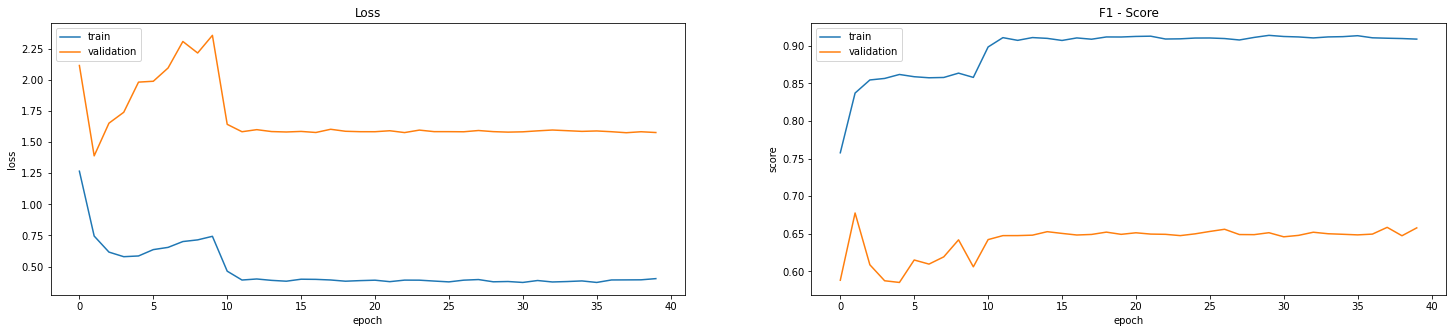

------------------------------ Second training ------------------------------


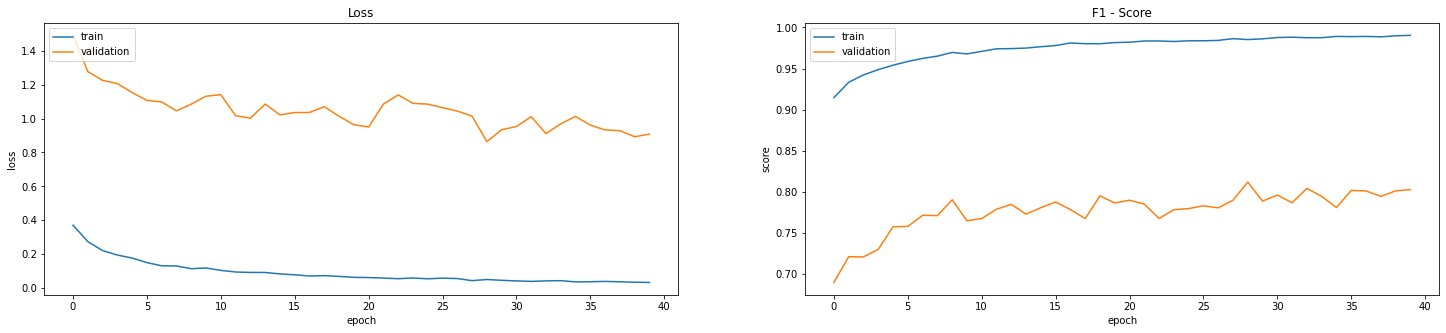

In [41]:
####################################################################################
############# Executer les fonctions utiles à la fin du notebook avant #############
####################################################################################

plot_history(freeze_hist, name = "First training")
plot_history(hist, name = "Second training")

Une fois notre modèle entrainé, les poids du meilleur réseau ont été sauvegardés dans un fichier model_no_aug_best.h5.  

Nous rechargeons le modèle afin de l'évaluer sur notre jeu de test.   

In [42]:
model = keras.models.load_model('model_style_test.h5')

In [43]:
####################################################################################
############# Executer les fonctions utiles à la fin du notebook avant #############
####################################################################################
report = report_evaluation(model, test, train['label_name'].cat.categories.tolist())

------------------------------ Evaluation Report ------------------------------ 

Test Size : Found 1265 validated image filenames.

Report : 

F1_score macro: 0.7804413946088472
Accuracy:  0.8102766798418972


## Annexe :  Fonctions utiles

In [39]:
def plot_history(hist, name = "Training"):
    print("-"*30, name, "-"*30)
    plt.figure(figsize=(25,5))
    
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","validation"], loc="upper left")
    
    plt.subplot(1,2,2)
    plt.plot(hist.history["f1_score"])
    plt.plot(hist.history["val_f1_score"])
    plt.title("F1 - Score")
    plt.ylabel("score")
    plt.xlabel("epoch")
    plt.legend(["train","validation"], loc="upper left")
    
    plt.show()

In [40]:
def report_evaluation(model, test_df, class_indices, image_size=120, batch_size=32, verbose = 1):
    
    if verbose > 0:
        print("-"*30,"Evaluation Report","-"*30,"\n")
    datagen_test = ImageDataGenerator()
    
    if verbose > 0:
        print("Test Size :", end=' ')
    test_generator = datagen_test.flow_from_dataframe(dataframe=test_df, 
        x_col="name",
        shuffle=False,
        target_size=(image_size,image_size), 
        batch_size=batch_size,
        class_mode=None,
        rescale=1.0/255,
        seed=2020 )
    
    if verbose > 0:
        print("\nReport : \n")
    probabilities = model.predict(test_generator)
    y_pred = np.argmax(probabilities,1)
    y_test = np.array(test_df["label"])
    
    score_f1 = f1_score(y_test, y_pred, average="macro")
    score_acc = accuracy_score(y_test, y_pred)
    
    if verbose > 0:
        print("F1_score macro:", score_f1)
        print("Accuracy: ", score_acc)
    
    return score_f1, score_acc, y_pred, y_test, np.max(probabilities,1)